# SENG474 Project Report
##  Multi-Category Classification to Identify Japanese Katakana Character


#### Jue Fu V00863998 | Arthur Wang V00847655 | Waltvin Lee V00894034

####  Dec 4 2019

## 1 Introduction
In this project, we apply data mining techniques to the classical machine learning problem of hand-written & machine printed character recognition. Language with a smaller alphabet is preferred to keep the training cycle short. So we choose a handwritten database of Japanese katakana for higher application value.


## 2 Data Collection
Our dataset is taken from the ETL character database, which is a collection of images of about 1.2 million hand-written and machine-printed numerals, symbols, Latin alphabets and Japanese characters that compiled in 9 datasets (ETL-1 to ETL-9).[1].

We will be using the ETL-5 provided dataset that consists of **51 Katakana characters**.

We read a binary format file to extract the pixels and reshape them into **10608  (50*208) hand-written images** of size **72x76 pixels**, however there was a large amount of white space margin, therefore we have decided to crop the margin of every image down to **50x50 pixels**. 

During data elicitation, we have found that there were 3 duplicate characters that appeared twice, which will cause our classifier to classify one to another. These duplicate characters will also have twice the amount of data instances, and would be inconsistent with other characters, therefore we as a group have decided to remove the duplicates of these 3 characters, reducing our dataset to now consist **48 kinds of Katakana characters**.

In [2]:
# !pip install numpy
# !pip install matplotlib
# !pip install sklearn

/bin/sh: 1: sudo: Permission denied


In [2]:
import struct
import numpy as np
from matplotlib import pyplot as plt
import math
import time
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron

## 3 Data Preprocessing and Visualization
To obtain the information from the ETLC-5 file, we write the following helper functions. [2]

### 3.1 read_record()
The read_record() function will return an array of 4 bit color representation of a hand-written instance.

The Japanese database provides only binary files in the following format: 



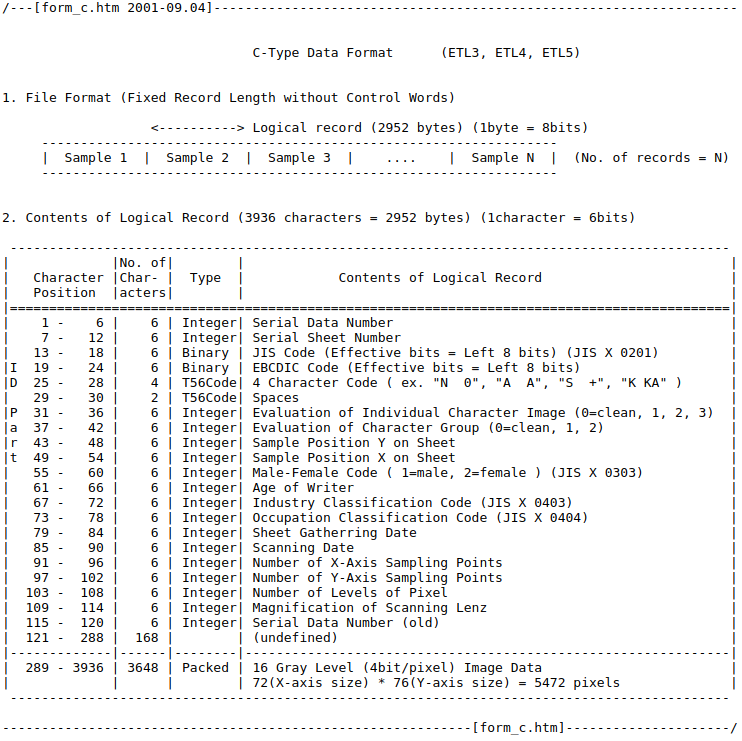


In this function `struct` library is applied to unpack bits from binary file. 

Each record contains the info of a hand-written image. 

The function reads pixel by pixel starting from the offset and then append them to a list. 

The list `pixels` carrying all the 4-bit greyscale representation of pixels from a single image would be returned. Therefore the length of `pixels` would be the count of all pixels in an image which equals height * width (72*76).


In [3]:
# An instance record has 2952 bytes. (1 byte = 8 bits) (1 character = 6bits) (4bit/pixel) 
# 72(X-axis size) * 76(Y-axis size) = 5472 pixels
size_record = 2952

#Pixels will contain an array of the 4 bit color representation of a hand-written instance
def read_record(f):
    pixels = []
    s = f.read(size_record)
    str_data = struct.unpack_from('>2736s',s,216)[0]
    offset = 0
    while offset < len(str_data):
        # [2:] removes the 0b at the front, zfill appends zeros at the front to ensure 8 bits
        byte = bin(int(str_data[offset]))[2:].zfill(8)
        
        # Append to pixels array, 1 byte (2 pixels) at a time
        pixels.append(byte[0:4])
        pixels.append(byte[4:8])
        offset = offset + 1
    pixels = [float(x) for x in pixels]
    return pixels

### 3.2 read_katakana()
The read_katakana() function will return a 4d array with values of 4 bit color representation of the form of arr[Char No, Instance No, X, Y]

In [4]:
def read_katakana():
    # 48: number of katakana characters
    # 208: number of images for each katakana
    # 50*50: image size
    arr = np.zeros([48,208,50,50], dtype=np.float32)
    filename = 'ETL5C'
    with open(filename, 'rb') as f:
        i = 0
        char_offset = 0
        while i < 10608:
        # for i in range(500):
            pixels_arr = np.array(read_record(f))
            pic = np.reshape(pixels_arr,(76,72)).astype(np.float32)
            
            # Crop image to 50px,50px
            pic = pic[13:63,11:61]
            
            # Remove characters number 36, 38, 47 since they are duplicates
            if math.floor(i/208) in [36,38,47]:
                if i in [36*208, 38*208, 47*208]:
                    char_offset = char_offset + 1
                i = i + 1
                continue
            arr[math.floor(i/208)-char_offset,i%208]= pic
            i = i + 1
    return arr

arr = read_katakana()

### 3.3 Viewing the image using plt.imshow
As shown below, read_katakana() returns a 4d array, the array will be in the form of arr[Char No, Instance No, x, y].

We use plt.imshow with argument arr[0][0] to print the image of the 1st character and the 1st instance.

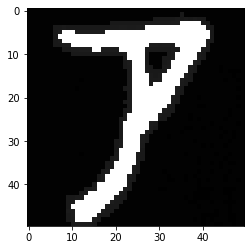

In [27]:
def view_image(arr,idx,inst):
    
    plt.imshow(arr[idx][inst], cmap='gray', interpolation='nearest')
    # following commented code could also save image to local
    # plt.savefig("pic{:04d}.png".format(idx)) #save image as file
    # print("{:04d} finished.".format(idx))
    
view_image(arr,0,0)

## 4 Data Mining
Now that we have all the hand-written instances stored conveniently in an array given by the read_katakana() function, we can start the data mining process using the algorithms we have learnt.

We define the functions of the algorithms that we are going to use.

In [6]:
#char_list is used to record the total number of correct predictions for a given character for all 6 classifiers
char_list = np.zeros(48)

def linearSVC(X,y,Xte,yte):
    print("Processing LinearSVC...")
    clf = LinearSVC(max_iter=2000)
    clf.fit(X, y)
    Xte_res = clf.predict(Xte)
    comp(Xte_res,yte)

def logisticReg(X,y,Xte,yte):
    print("Processing Logistic Regression...")
    logreg = LogisticRegression()
    logreg.fit(X, y)
    Xte_res = logreg.predict(Xte)
    comp(Xte_res,yte)

def naiveBayes(X,y,Xte,yte):
    print("Processing Gaussian Native Bayes...")
    nb = GaussianNB()
    nb.fit(X, y)
    Xte_res = nb.predict(Xte)
    comp(Xte_res,yte)

def kNeighbour(X,y,Xte,yte):
    print("Processing KNeighbour...")
    knn = KNeighborsClassifier()
    knn.fit(X, y)
    Xte_res = knn.predict(Xte)
    comp(Xte_res,yte)

def decisionTree(X,y,Xte,yte):
    print("Processing Decision Tree...")
    tree = DecisionTreeClassifier()
    tree.fit(X, y)
    Xte_res = tree.predict(Xte)
    comp(Xte_res,yte)

def perceptron(X,y,Xte,yte):
    print("Processing Perceptron...")
    percep = Perceptron()
    percep.fit(X, y)
    Xte_res = percep.predict(Xte)
    comp(Xte_res,yte)
    
def comp(Xte_res,yte):
    
    global char_offset
    
    match_num = 0
    match_list = np.zeros(48)
    print("Actual - Pred")
    for i in range(len(Xte_res)):
        if Xte_res[i] == yte[i]:
            match_list[int(yte[i])] = match_list[int(yte[i])] + 1
            char_list[int(yte[i])] = char_list[int(yte[i])] + 1
            match_num = match_num + 1
        
        print("{0:02.0f} ------ {1:02.0f}".format(yte[i],Xte_res[i]))
    
                          
    for i in range(len(match_list)):
        print("Character = {0:02.0f}, Correct Predictions = {1:.0f}/10, % = {2:.2f}".format(i, match_list[i], (match_list[i]/10)* 100))
    
    print("All {0} test samples, {1} Correct Predictions. Accuracy is {2:.2f}%.".format(len(yte),match_num,(match_num/len(yte))*100))
    # return match_list[i]

### 4.1 Training & Testing
We have 208 instances for each character, therefore we have decided to use 198 Training instances, and 10 Testing instances. We have chosen the first 198 instance to be training instances, and the final 10 instances to be testing instances.

In [7]:
def training(arr, classifier):
    # prepare X and y
    train_sz = 198
    test_sz = 10
    X = np.zeros([train_sz*48, 50*50], dtype=np.float32)
    Xte = np.zeros([test_sz*48, 50*50], dtype=np.float32)

    # get training matrix X, training label y, testing matrix Xte, testing label yte
    for i in range(48):
         train_pics = arr[i,0:train_sz,:,:]
         train_tuples = np.reshape(train_pics,(train_sz,50*50))
         X[i*train_sz:(i+1)*train_sz , :] = train_tuples

         test_pics = arr[i,train_sz:train_sz+test_sz,:,:]
         test_tuples = np.reshape(test_pics,(test_sz,50*50))
         Xte[i*test_sz:(i+1)*test_sz,:] = test_tuples

    y = np.zeros([train_sz*48])
    yte = np.zeros([test_sz*48])

    for i in range(train_sz*48):
        y[i] = math.floor(i/train_sz)

    for i in range(test_sz*48):
        yte[i] = math.floor(i/test_sz)
        
    if (classifier == 0):
        kNeighbour(X,y,Xte,yte)
    elif (classifier == 1):
        linearSVC(X,y,Xte,yte)
    elif (classifier == 2):
        logisticReg(X,y,Xte,yte)
    elif (classifier == 3):
        naiveBayes(X,y,Xte,yte)
    elif (classifier == 4):
        decisionTree(X,y,Xte,yte)
    elif (classifier == 5):
        perceptron(X,y,Xte,yte)

### 4.2 Results for KNeighbour

In [8]:
start = time.time()
training(arr,0) #KNeighbour
end = time.time()
print("Total Time Taken = {}s".format((end - start),))

Processing KNeighbour...
Actual - Pred
00 ------ 00
00 ------ 00
00 ------ 18
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 07
00 ------ 00
00 ------ 20
00 ------ 00
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 00
01 ------ 01
01 ------ 17
01 ------ 01
02 ------ 02
02 ------ 27
02 ------ 18
02 ------ 43
02 ------ 43
02 ------ 02
02 ------ 02
02 ------ 38
02 ------ 17
02 ------ 07
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 36
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 18
03 ------ 29
04 ------ 04
04 ------ 33
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 37
04 ------ 24
05 ------ 05
05 ------ 24
05 ------ 24
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 24
05 ------ 07
05 ------ 07
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 03
06 ------ 06
07 ------ 07
07 ------ 24
07 ------ 07
07 ------ 27

### 4.3 Results for Linear Regression

In [9]:
start = time.time()
training(arr,1) #Linear Regression
end = time.time()
print("Total Time Taken = {}s".format((end - start),))

Processing LinearSVC...
Actual - Pred
00 ------ 07
00 ------ 00
00 ------ 46
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 09
00 ------ 30
00 ------ 04
00 ------ 46
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 46
01 ------ 01
01 ------ 10
01 ------ 18
01 ------ 01
01 ------ 01
01 ------ 01
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 05
02 ------ 05
02 ------ 27
02 ------ 07
03 ------ 45
03 ------ 45
03 ------ 45
03 ------ 34
03 ------ 36
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 45
03 ------ 03
04 ------ 04
04 ------ 37
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 33
04 ------ 04
04 ------ 04
04 ------ 23
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 37
05 ------ 29
05 ------ 05
06 ------ 16
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 38
06 ------ 38
06 ------ 16
06 ------ 06
06 ------ 04
06 ------ 06
07 ------ 39
07 ------ 10
07 ------ 02
07 ------ 43


### 4.4 Results for NaiveBayes

In [10]:
start = time.time()
training(arr,3) #NaiveBayes
end = time.time()
print("Total Time Taken = {}s".format((end - start),))

Processing Gaussian Native Bayes...
Actual - Pred
00 ------ 00
00 ------ 00
00 ------ 27
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 27
00 ------ 27
00 ------ 00
00 ------ 00
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 43
02 ------ 43
02 ------ 43
02 ------ 02
02 ------ 30
02 ------ 27
02 ------ 18
03 ------ 45
03 ------ 45
03 ------ 21
03 ------ 21
03 ------ 44
03 ------ 33
03 ------ 21
03 ------ 21
03 ------ 21
03 ------ 21
04 ------ 04
04 ------ 04
04 ------ 12
04 ------ 12
04 ------ 04
04 ------ 04
04 ------ 33
04 ------ 04
04 ------ 04
04 ------ 27
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 31
05 ------ 31
05 ------ 05
05 ------ 31
05 ------ 05
05 ------ 05
05 ------ 25
06 ------ 44
06 ------ 34
06 ------ 06
06 ------ 06
06 ------ 46
06 ------ 18
06 ------ 06
06 ------ 06
06 ------ 31
06 ------ 31
07 ------ 00
07 ------ 07
07 ------ 27
0

### 4.5 Results for Decision Tree

In [11]:
start = time.time()
training(arr,4) #DecisionTree
end = time.time()
print("Total Time Taken = {}s".format((end - start),))

Processing Decision Tree...
Actual - Pred
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 20
00 ------ 00
00 ------ 00
00 ------ 24
00 ------ 14
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 38
02 ------ 02
02 ------ 02
02 ------ 28
02 ------ 02
02 ------ 43
02 ------ 07
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 45
03 ------ 03
03 ------ 36
03 ------ 03
03 ------ 45
03 ------ 03
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 12
04 ------ 04
04 ------ 04
04 ------ 38
04 ------ 04
04 ------ 04
04 ------ 04
05 ------ 17
05 ------ 05
05 ------ 05
05 ------ 27
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
06 ------ 06
06 ------ 46
06 ------ 29
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 31
07 ------ 14
07 ------ 07
07 ------ 07
07 ------

### 4.6 Results for Perceptron

In [12]:
start = time.time()
training(arr,5) #Perceptron
end = time.time()
print("Total Time Taken = {}s".format((end - start),))

Processing Perceptron...
Actual - Pred
00 ------ 07
00 ------ 00
00 ------ 46
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 09
00 ------ 00
00 ------ 00
00 ------ 46
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 46
01 ------ 01
01 ------ 10
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 05
02 ------ 38
02 ------ 27
02 ------ 02
03 ------ 03
03 ------ 45
03 ------ 45
03 ------ 34
03 ------ 21
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 45
03 ------ 03
04 ------ 04
04 ------ 37
04 ------ 04
04 ------ 12
04 ------ 05
04 ------ 04
04 ------ 37
04 ------ 04
04 ------ 37
04 ------ 23
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 04
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 37
05 ------ 05
05 ------ 05
06 ------ 06
06 ------ 06
06 ------ 37
06 ------ 06
06 ------ 38
06 ------ 38
06 ------ 37
06 ------ 06
06 ------ 04
06 ------ 06
07 ------ 07
07 ------ 27
07 ------ 27
07 ------ 09

### 4.7 Results for Logistic Regression

In [13]:
start = time.time()
training(arr,2) #Logistic Regression
end = time.time()
print("Total Time Taken = {}s".format((end - start),))

Processing Logistic Regression...


D:\OtherStuff\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\OtherStuff\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Actual - Pred
00 ------ 00
00 ------ 00
00 ------ 46
00 ------ 00
00 ------ 00
00 ------ 00
00 ------ 09
00 ------ 30
00 ------ 00
00 ------ 46
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 46
01 ------ 01
01 ------ 10
01 ------ 01
01 ------ 01
01 ------ 01
01 ------ 01
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 02
02 ------ 05
02 ------ 38
02 ------ 27
02 ------ 07
03 ------ 45
03 ------ 45
03 ------ 45
03 ------ 34
03 ------ 36
03 ------ 03
03 ------ 03
03 ------ 03
03 ------ 45
03 ------ 03
04 ------ 04
04 ------ 37
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 04
04 ------ 33
04 ------ 04
04 ------ 04
04 ------ 23
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 05
05 ------ 37
05 ------ 29
05 ------ 05
06 ------ 16
06 ------ 06
06 ------ 06
06 ------ 06
06 ------ 38
06 ------ 38
06 ------ 16
06 ------ 06
06 ------ 04
06 ------ 06
07 ------ 07
07 ------ 10
07 ------ 07
07 ------ 43
07 ------ 07
07 ------ 0

### 4.8 Results for each individual character
Below shows the results for each individual character, when being classified with all 6 classifiers.

In [14]:
 for i in range(len(char_list)):
        print("Character = {0:02d}, Total Correct = {1:.0f}/60, Total % = {2:.2f}".format(i, char_list[i], (char_list[i]/(10*6)* 100)))

Character = 00, Total Correct = 37/60, Total % = 61.67
Character = 01, Total Correct = 50/60, Total % = 83.33
Character = 02, Total Correct = 32/60, Total % = 53.33
Character = 03, Total Correct = 27/60, Total % = 45.00
Character = 04, Total Correct = 39/60, Total % = 65.00
Character = 05, Total Correct = 43/60, Total % = 71.67
Character = 06, Total Correct = 35/60, Total % = 58.33
Character = 07, Total Correct = 25/60, Total % = 41.67
Character = 08, Total Correct = 35/60, Total % = 58.33
Character = 09, Total Correct = 44/60, Total % = 73.33
Character = 10, Total Correct = 26/60, Total % = 43.33
Character = 11, Total Correct = 30/60, Total % = 50.00
Character = 12, Total Correct = 39/60, Total % = 65.00
Character = 13, Total Correct = 26/60, Total % = 43.33
Character = 14, Total Correct = 36/60, Total % = 60.00
Character = 15, Total Correct = 20/60, Total % = 33.33
Character = 16, Total Correct = 19/60, Total % = 31.67
Character = 17, Total Correct = 38/60, Total % = 63.33
Character 

## 5 Evaluation
### 5.1 Overall Classifier Performance
With a random classifier that takes random guesses, the accuracy would be 1/48, equivalent to 2.08% , as there are 48 classes. However, using the classifiers, we get an accuracy of around 55%, which is a significant improvement compared to a random classifier.

| Classifier | Accuracy | Time Taken |
| ----------- | ----------- | ----------- |
| KNeighbour | 58.33% | 22.25s |
| Linear Regression | 53.33% | 119.86s |
| Naive Bayes | 51.88% | 1.33s |
| Decision Tree | 57.70% | 8.30s |
| Perceptron | 52.29% | 49.33s |
| Logistic Regression | 55.63% | 513.29s |

### 5.2 Classifier Performance on Individual Characters
The lowest accuracy on a single character is 0%, which has occured with character 15 using the KNeighbour Classifier. This is particularly bad because the accuracy of a random classifier that takes random guesses will be 2.08%, meaning a random classifier will be correct 2.08% of the time when given samples of character 15. However, KNeighbour provided us with a 0% accuracy for this specific character. The cause of this is probably beacause of the close similarity in character 15 and character 7 and the behavior of the KNeighbour classifier. More on this is covered in Section 6.1.

### 5.3 Best Classifier
#### 5.3.1 KNeighbour
Eventhough KNeighbour has the highest accuracy of 58.33%, the total time taken for training and testing is 22.25s, which can be considered as pretty high relative to some of the other classifiers. 
#### 5.3.2 Decision Tree
Decision Tree has a slightly reduced accuracy of 57.70%, but the time taken is 8.30s, approximately 14s faster compared to KNeighbour. Depending on the situation, Decision Tree may be a better choice in a time-limited situation. 
#### 5.3.3 Naive Bayes
Naive Bayes can also be considered as it requires a significantly lower time of 1.33s, but trading off with quite an amount of accuracy, resulting in 51.88%
#### 5.3.4 Other Classifiers
The other classifiers performed badly in both terms of accuracy and time taken.

## 6 Discussion
### 6.1 KNeighbour's accuracy of 0% on Character 15
We can see from the results of KNeighbour above, that the classifier predicted 7 out of 10 of the samples to be character 7. Below shows the character 15 on the left, and character 7 on the right. We can see the very close similarities of these 2 characters and understand why the classifier is having trouble on classifying this character.

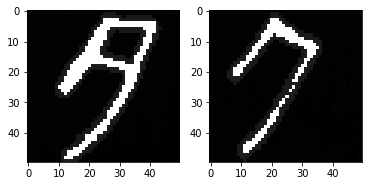

In [23]:
fig = plt.figure()
fig.add_subplot(1,2,1)
view_image(arr,15,0)
fig.add_subplot(1,2,2)
view_image(arr,7,0)

### 6.2 Things that might have decreased the accuracy
#### 6.2.1 Image Alignment
The images are not aligned properly, in which characters may be written at different positions which caused difficulties to some classifiers. eg. a character may be written at the top left for one instance, and at the bottom right for another instance. Some of the steps we could have taken was to align the leftmost white pixel to the left and the bottom-most white pixel to the bottom to help align all the character's position in each image to the bottom left. The example below shows the horizontal stroke being completely different in coordinate positions. The left is within x=10 and x=20, whereaas the right is within x=20 and x=30.

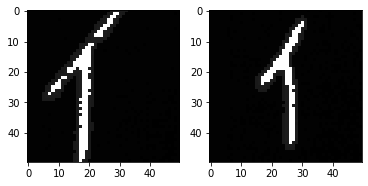

In [15]:
fig = plt.figure()
fig.add_subplot(1,2,1)
view_image(arr,1,0)
fig.add_subplot(1,2,2)
view_image(arr,1,15)

#### 6.2.2 Image Size
Some of the image may look very similar, but their sizes are significantly different which caused the color pixel locations to vary by a lot. The example below shows this. It is difficult for a classifier to work with these images. An improvement that should be done was to resize/rescale the right image to fit the entire 50x50 pixel area before performing training/testing.

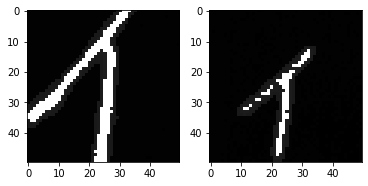

In [16]:
fig = plt.figure()
fig.add_subplot(1,2,1)
view_image(arr,1,25)
fig.add_subplot(1,2,2)
view_image(arr,1,13)

#### 6.2.3 Katakana Characters Similarity
Some Katakana characters are highly similar and only have a few small differences in strokes. Classifiers have a difficult time in differenciating between them. An example are the 2 characters below.

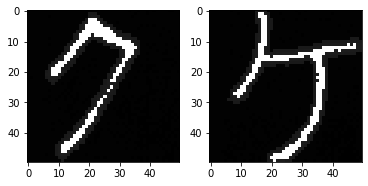

In [17]:
fig = plt.figure()
fig.add_subplot(1,2,1)
view_image(arr,7,0)
fig.add_subplot(1,2,2)
view_image(arr,8,0)

#### 6.2.4 Katakana Characters Complexity
Character 23, shown below, has the lowest overall accuracy of 21.67% when considering all 6 classifiers. The character 23 is the character with the largest about of strokes and can be considered to be the most complex. From our results we can tell that classifiers have a more difficult time in classifying complex characters.

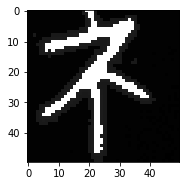

In [26]:
fig = plt.figure()
fig.add_subplot(1,2,1)
view_image(arr,23,0)

### 6.3 What to improve on
#### 6.3.1 Image alignment
All images can be first aligned to a specific location, for example to the bottom left. This will help all images to be consistently appearing in a specific location and not all around the place, which will help similar features/strokes of the character to be more consistent in one coordinate between all the instances.

#### 6.3.2 Image re-size/re-scale
All images could be resized or rescaled to fit the full 50x50 pixel area before performing classification or training so that their features can be more properly identified as the inconsistent sizes between the instances are eliminated.

#### 6.3.3 Additional image features
Additional image features such as number of colored pixels, number of strokes, number of closed loops and so forth can be used to help the classifier.


### 6.4 Next steps
Intuitively when people see images, they recognize the whole shape and relate neighbour pixels together. With the ability to identify the border of character, we could identify with image translation and scaling. 
A CNN (Convolutional Neural Network) would be more ideal in this case and it has shown great results since it's invented.
To avoid losing spatial interactions between pixels, a CNN effectively uses adjacent pixel information to  downsample the image by convolution and then apply a prediction layer at the end.


## 7 Conclusion 
In this project, we used data mining techniques to recognize Japanese katakana and applied several classifiers to predict them. The overall accuracy is around 55% and the accuracy variation among classifiers are small. It is highly possible that our classifiers identify the right character. Due to the complexity of characters and quality of image, more engineering skills and better image processing algorithms could be applied to improve accuracy.

## 8 Acknowledgements
This report presents the project of 2019 fall data mining course. We would like to express our great appreciation to professor Dr. Alex Thomo and lab instructor Yudi Santoso for the guidance and assistance during the course.

## 9 References
- [1] “About the ETL Character Database,” etlcdb. [Online]. Available: http://etlcdb.db.aist.go.jp/. [Accessed: 25-Nov-2019].

- [2] "How I built a handwriting recognizer and shipped it to the App Store", freeCodeCamp.org, 2019. [Online]. Available: https://www.freecodecamp.org/news/build-a-handwriting-recognizer-ship-it-to-app-store-fcce24205b4b/. [Accessed: 25- Nov- 2019].

- [3] Ujjwalkarn, “An Intuitive Explanation of Convolutional Neural Networks,” the data science blog, 29-May-2017. [Online]. Available: https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/. [Accessed: 05-Dec-2019].

